If using Colab you'll need to instal the following packages


In [1]:
!pip install tensorflow_addons
!pip install imgaug==0.4

In [2]:

from google.colab import drive
import sys
import os
from tensorflow.keras.utils import plot_model
from PIL import Image
import numpy as np

drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/repo dup/Guava") # Here insert path to the folder containing the python scripts

from Model import CNNAE, EFFNET 
from Dataset import Dataset
import utils


py_file_location = "/content/drive/MyDrive/BU_Guava_Leaf-BUGL2018/" #Insert here the path for the Dataset containting training_set and test_set
test_path= os.path.join(py_file_location,"test_set")
train_path= os.path.join(py_file_location,'training_set')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Training and Validation sets for Autoencoder training


In [3]:
validationDataset= Dataset(path=test_path,is_val=True, batch_size=16, Eff=False)
trainDataset= Dataset(path=train_path, batch_size=16, Eff=False)

Algal leaf spot
Healthy leaf
Rust
Whitefly
Algal leaf spot
Healthy Leaf
Rust
Whitefly


Visualizing input training image for the AE

*For AE training random augemntations are applied to the images*

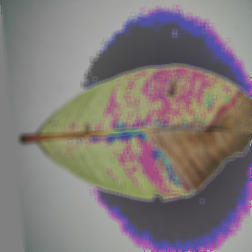

In [4]:
x,y=trainDataset.__getitem__(16)  # (number of batch to selectfrom)
someImage=y["Dec"][2]*255  # [number of image in the batch]
Image.fromarray(someImage.astype("uint8"))

Visualizing input validation image for the AE

*For AE training random augemntations are applied to the images in addition to opencv based segmentation*

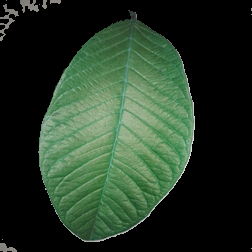

In [5]:
x,y=validationDataset.__getitem__(13) # (number of batch to selectfrom)
someImage=y["Dec"][2]*255   # [number of image in the batch]
Image.fromarray(someImage.astype("uint8"))

Initialize the model in addition to showing summary

In [6]:
newmodel=CNNAE()
newmodel.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 252, 252, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 252, 252, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 126, 126, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 32) 4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

Visualizing the model

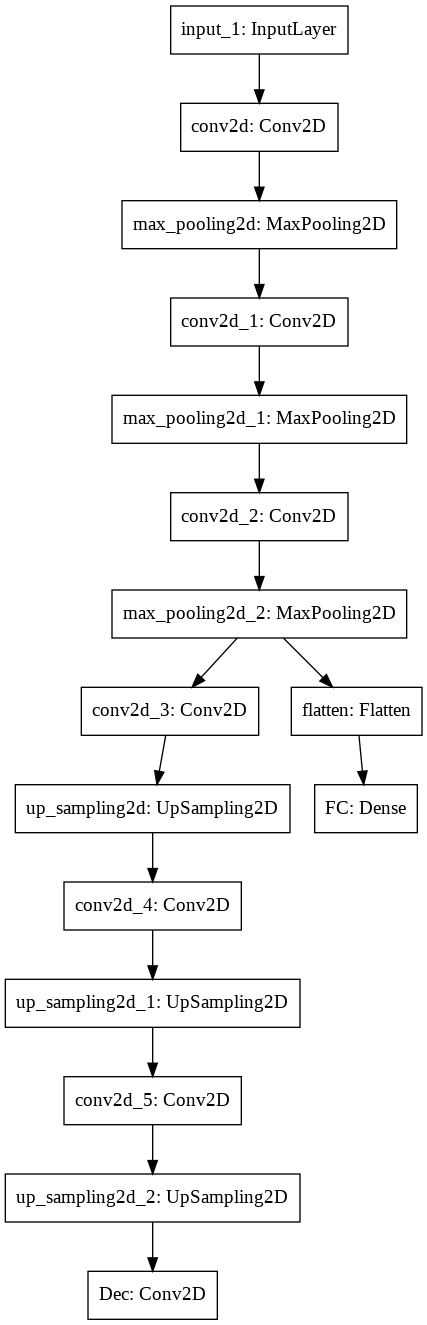

In [7]:
plot_model(newmodel.model)

Training the CNN-Autoencoder

In [8]:
newmodel.train_AE(trainDataset,validationDataset,Nepoch=15)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 252, 252, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 252, 252, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 126, 126, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 32) 4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

Create training and validation datasets for the Classifier

In [9]:
validationDataset2= Dataset(path=test_path,is_val=True,AE=False, Eff=False)
trainDataset2= Dataset(path=train_path,AE=False,batch_size=16, Eff=False)

Algal leaf spot
Healthy leaf
Rust
Whitefly
Algal leaf spot
Healthy Leaf
Rust
Whitefly


Visualizing input training image for the Classifier

*For Classifier training random augemntations are applied to the images in addition to opencv based segmentations*

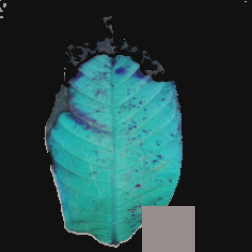

In [10]:
x,y=trainDataset2.__getitem__(28)  # (number of batch to selectfrom)
someImage=x[0]*255  # [number of image in the batch]
Image.fromarray(someImage.astype("uint8"))

Visualizing input validation image for the Classifier

*For Classifier validation random augemntations are applied to the images in addition to opencv based segmentations*

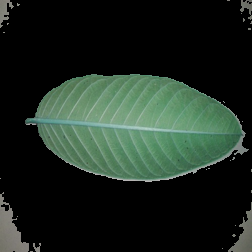

In [11]:
x,y=validationDataset2.__getitem__(24)  # (number of batch to selectfrom)
someImage=x[2]*255  # [number of image in the batch]
Image.fromarray(someImage.astype("uint8"))

Training the Classifier

In [12]:
newmodel.train_Classifier(trainDataset2,validationDataset2,Nepoch=30)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 252, 252, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 252, 252, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 126, 126, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 32) 4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

To save the model

In [13]:
Somepath='/content/drive/My Drive/repo_dup/Guava/savedModels'
newmodel.save_model(Somepath,"CNNAE_Model")

Choosing Images to visualize

In [14]:
XX, YY = validationDataset2[5] #choose which batch to visualize
pred = newmodel.model.predict(XX)
imageNum= 5     #choose some [number of image] to visualize an input image and CNN-AE output
Vis=XX[imageNum]*255  
outVis=pred[0][imageNum]*255

Visualize input image

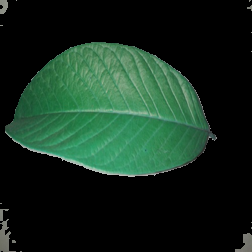

In [15]:
Image.fromarray(Vis.astype("uint8"))

Visualizing reconstructed image

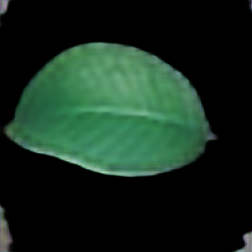

In [16]:
Image.fromarray(outVis.astype("uint8"))

Visualizing and graphing the results

Start off with with plotting the mean absoulute error for the Auto-Encoder

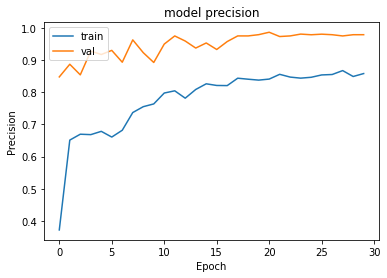

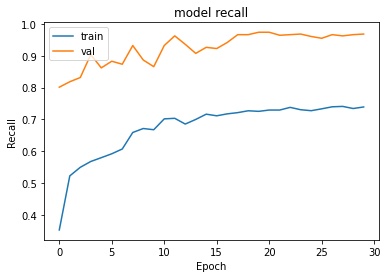

In [23]:
utils.plot_performance(newmodel.FC_history,EffNet=False, Classifier=True) 

Now we plot the model precision and recall for the Classifier

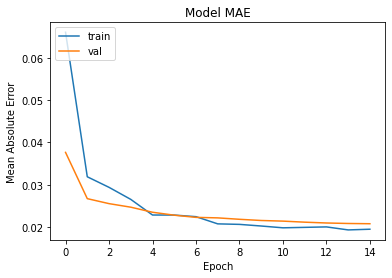

In [21]:
utils.plot_performance(newmodel.AE_history, EffNet=False, Classifier=False) 

In [24]:
XX,YY= [],[]
validationDataset2.on_epoch_end()
for x,y in validationDataset2:
  XX.append(x)
  YY.append(y["FC"])
XX=np.array(XX)
YY=np.array(YY)
YY=YY.reshape(-1,4)
XX=XX.reshape(-1,252,252,3)

XXpreds, YYpreds=newmodel.model.predict(XX)

shuffle done!


And here we can visualize the confusion matrix

Accuracy:
0.9772727272727273


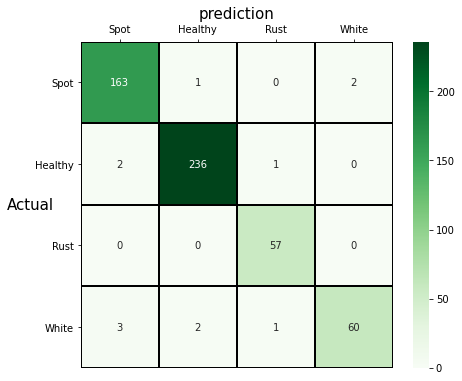

In [25]:
ypl, yt = utils.Decoding(YYpreds, YY.tolist())
yp = []
for i in range(len(ypl)):
  yp.append(ypl[i][0][0])
utils.scoring_system(yp, yt)